In [2]:
import json
import urllib.request
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [3]:
with open('processed_data.pkl', 'rb') as f:
    df=pickle.load(f)


Data processed and saved to pickle file.


### Average Resolution Time by Neighborhood

/tmp/ipykernel_106441/2671947620.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='neighborhood', y='resolution_time', data=average_resolution_time_by_neighborhood, palette='viridis')


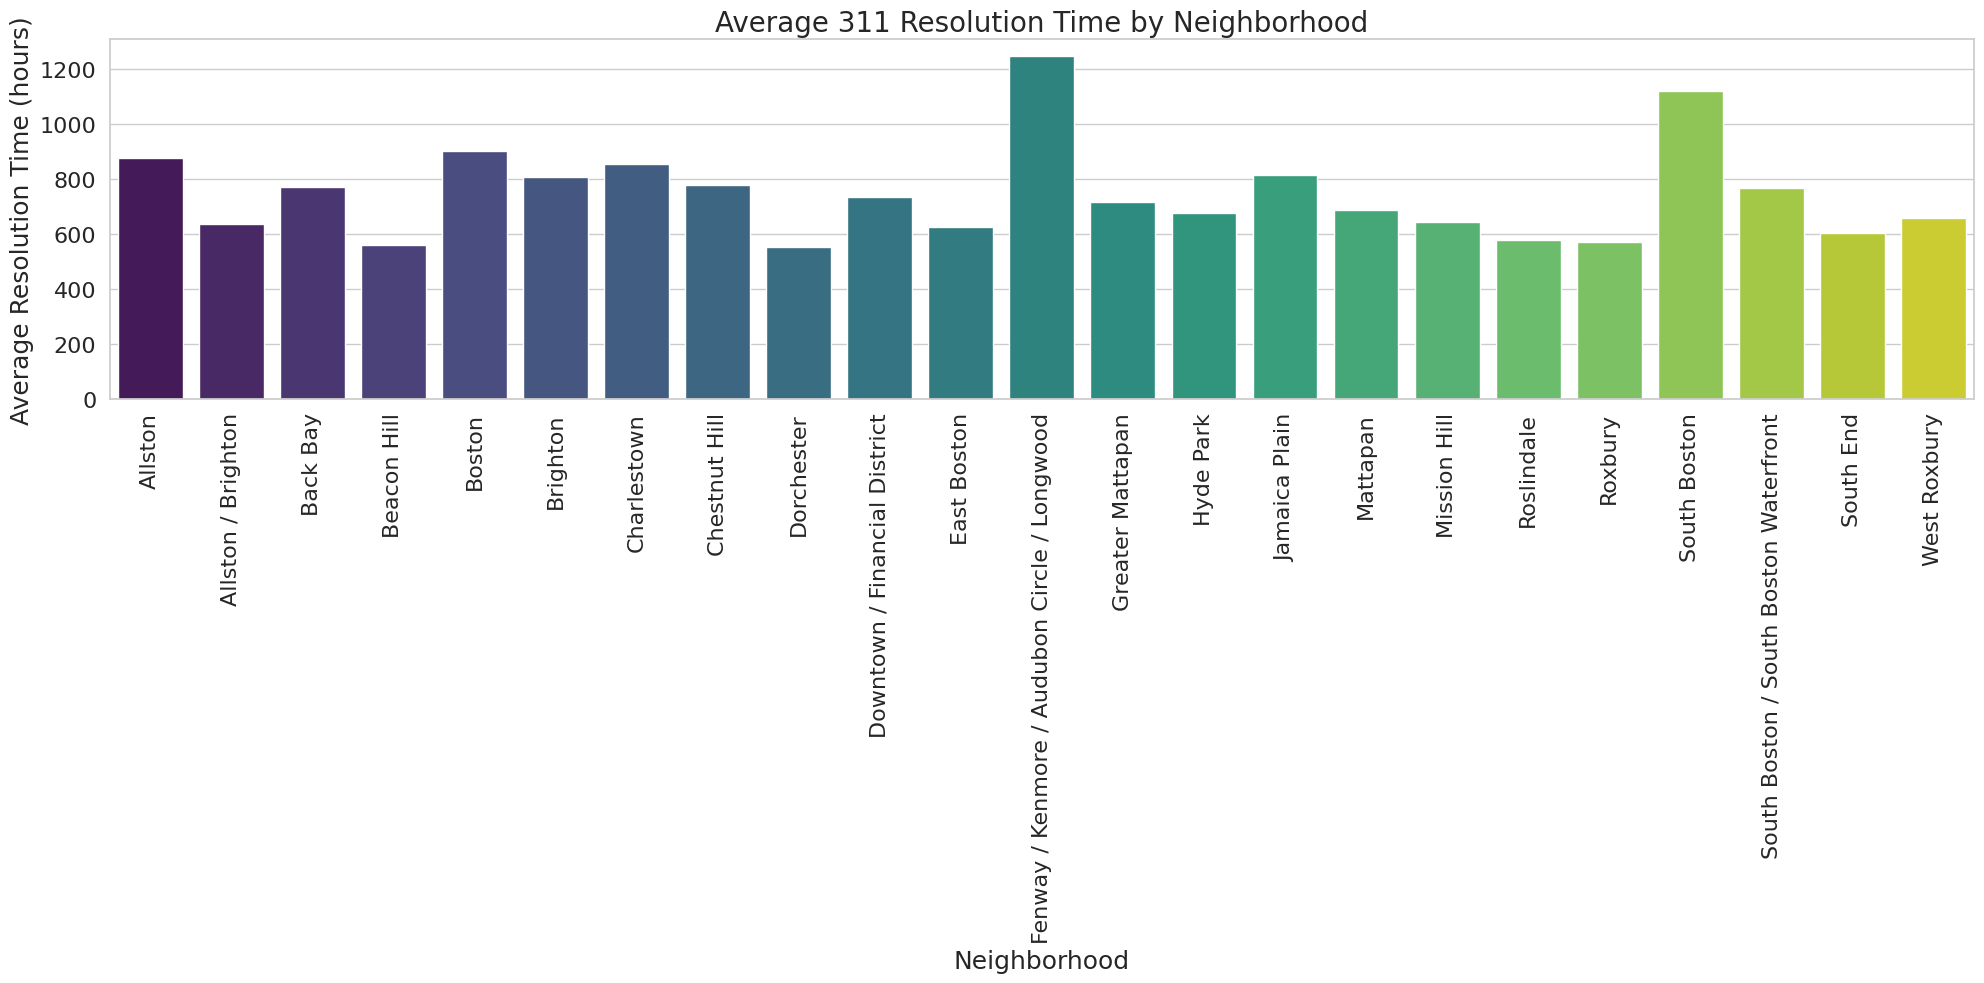

In [9]:
df['closed_dt'] = pd.to_datetime(df['closed_dt'], errors='coerce')
df['resolution_time'] = (df['closed_dt'] - df['open_dt']).dt.total_seconds() / 3600  # Resolution time in hours
df_res = df.dropna(subset=['neighborhood'])
df_res = df_res[df_res['neighborhood'] != ' ']
# Group by neighborhood and calculate the average resolution time
average_resolution_time_by_neighborhood = df_res.groupby('neighborhood')['resolution_time'].mean().reset_index()
# Create the visualization
plt.figure(figsize=(20, 10))  # Increase figure size

sns.barplot(x='neighborhood', y='resolution_time', data=average_resolution_time_by_neighborhood, palette='viridis')

plt.xlabel('Neighborhood', fontsize=18)
plt.ylabel('Average Resolution Time (hours)', fontsize=18)
plt.title('Average 311 Resolution Time by Neighborhood', fontsize=20)
plt.xticks(rotation=90, fontsize=16) # Adjust rotation and fontsize for x-axis labels
plt.yticks(fontsize=16)
# Adjust y-axis limits to accommodate the label
plt.subplots_adjust(bottom=0.2) # Adjust bottom margin

plt.tight_layout() # improve layout to avoid cutoff labels
plt.show()

### Sources Used to Issue Complaints By Neighborhood

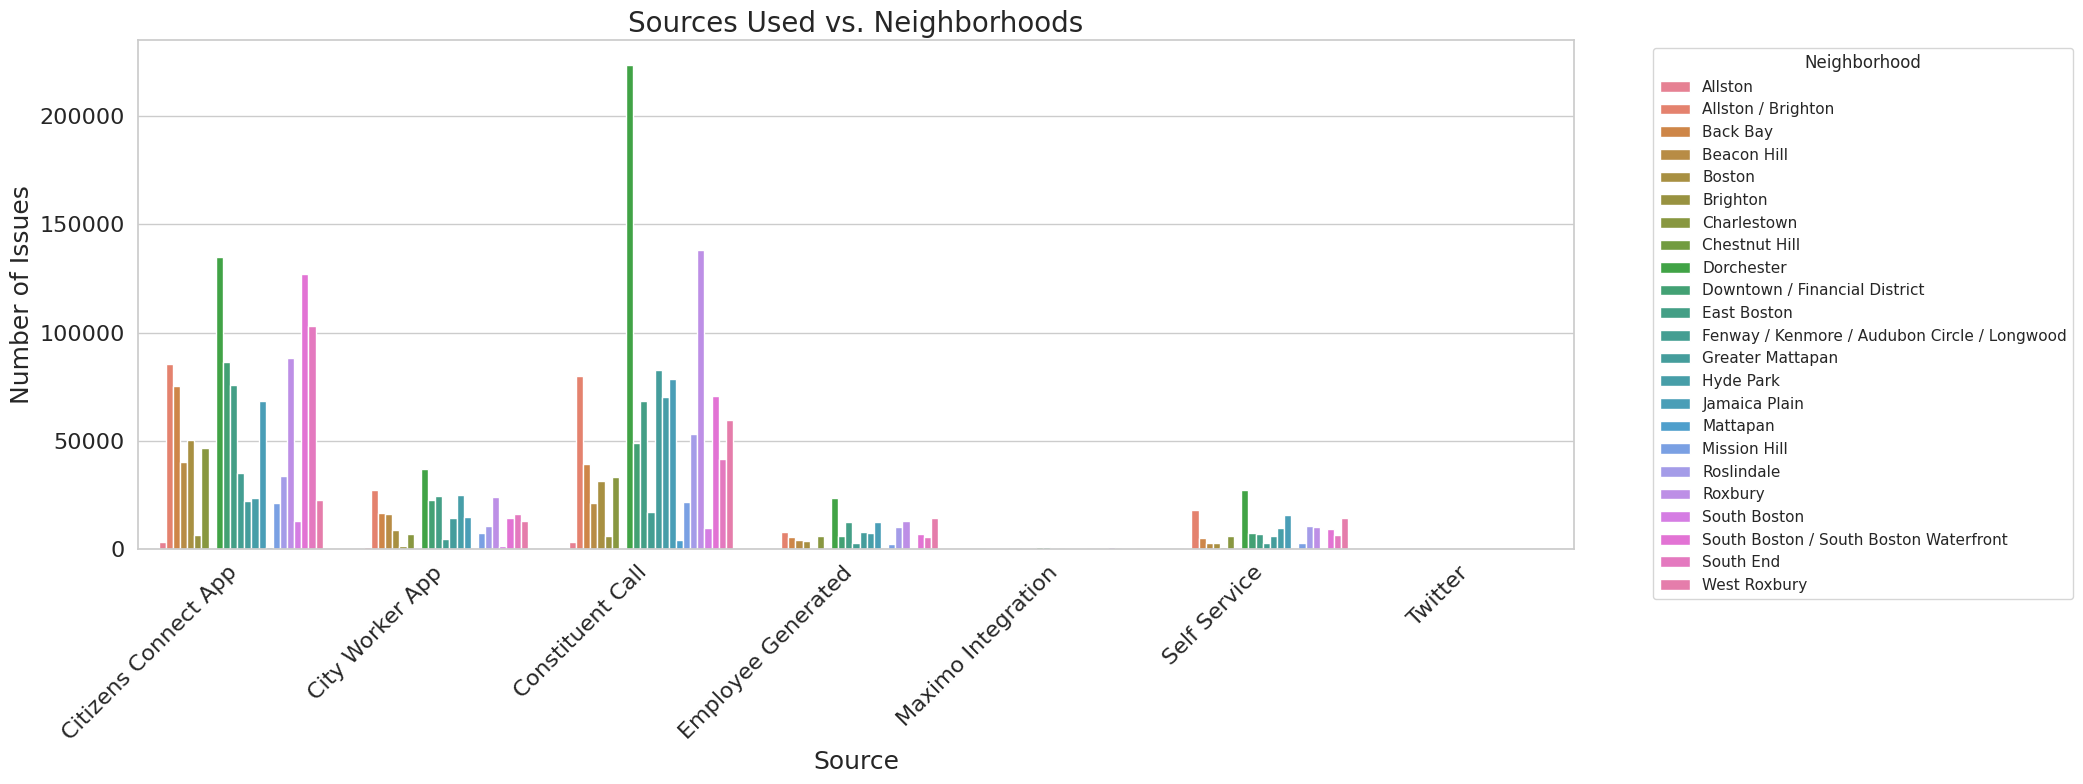

In [10]:
source_neighborhood_counts = df.groupby(['source', 'neighborhood']).size().reset_index(name='count')
# Create the visualization
plt.figure(figsize=(16, 8))  # Adjust figure size as needed

sns.barplot(x='source', y='count', hue='neighborhood', data=source_neighborhood_counts, palette='husl') # Use 'husl' for a colorful palette

plt.xlabel('Source', fontsize=18)
plt.ylabel('Number of Issues', fontsize=18)
plt.title('Sources Used vs. Neighborhoods', fontsize=20)

plt.xticks(rotation=45, ha='right', fontsize=16) # Rotate x-axis labels for better readability
plt.yticks(fontsize=16)

plt.tight_layout() # Ensures labels don't get cut off
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left') # Place legend outside the plot

plt.show()

### Seasonal Changes

In [6]:
# Extract month and season
df_filtered = df
df_filtered['month'] = df_filtered['open_dt'].dt.month
df_filtered['season'] = df_filtered['month'] % 12 // 3 + 1  # 1: Winter, 2: Spring, etc.

# Count total requests by season and year
df_filtered['season_year'] = df_filtered.apply(
    lambda row: row['year'] + 1 if row['season'] == 1 and row['month'] == 12 else row['year'],
    axis=1
)
seasonal_counts = df_filtered.groupby(['season_year', 'season']).size().reset_index(name='total_requests')
seasonal_counts = seasonal_counts[seasonal_counts['total_requests'] > 0]

print(seasonal_counts)

seasonal_neighborhood_counts = df_filtered.groupby(['season_year', 'season', 'neighborhood']).size().reset_index(name='total_requests')

df_filtered['closed_dt'] = pd.to_datetime(df_filtered['closed_dt'], errors='coerce')
df_filtered['resolution_time'] = (df_filtered['closed_dt'] - df_filtered['open_dt']).dt.days

# Group by season and calculate average resolution time
resolution_by_season = df_filtered.groupby(['season_year', 'season'])['resolution_time'].mean().reset_index()

type_season_counts = df_filtered.groupby(['type', 'season', 'season_year']).size().reset_index(name='total_requests')


    season_year  season  total_requests
0          2011       3           20500
1          2011       4           27029
2          2012       1           23740
3          2012       2           29767
4          2012       3           30524
5          2012       4           29597
6          2013       1           41114
7          2013       2           29705
8          2013       3           33903
9          2013       4           32298
10         2014       1           33361
11         2014       2           34700
12         2014       3           34744
13         2014       4           38677
14         2015       1           62162
15         2015       2           45283
16         2015       3           45040
17         2015       4           45975
18         2016       1           44569
19         2016       2           52830
20         2016       3           58030
21         2016       4           52605
22         2017       1           55540
23         2017       2           62406


Months in 2011: [6, 7, 8, 9, 10, 11, 12]
December 2010 rows: 7863
January and February 2011 rows: 0


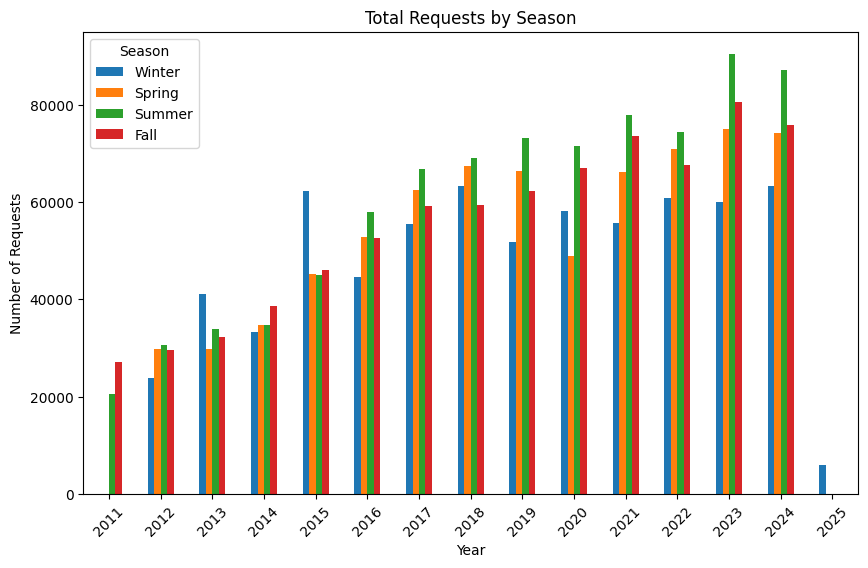

In [7]:

months_2011 = df_filtered[df_filtered['year'] == 2011]['month'].unique()
print("Months in 2011:", sorted(months_2011))

# Check for December 2010 data
dec_2010 = df_filtered[(df_filtered['year'] == 2011) & (df_filtered['month'] == 12)]
print(f"December 2010 rows: {len(dec_2010)}")

# Check for January and February 2011 data
jan_feb_2011 = df_filtered[(df_filtered['year'] == 2011) & (df_filtered['month'].isin([1, 2]))]
print(f"January and February 2011 rows: {len(jan_feb_2011)}")

seasonal_counts.pivot(index='season_year', columns='season', values='total_requests').plot(kind='bar', figsize=(10, 6))
plt.title('Total Requests by Season')
plt.xlabel('Year')
plt.ylabel('Number of Requests')
plt.xticks(rotation=45)
plt.legend(title='Season', labels=['Winter', 'Spring', 'Summer', 'Fall'])
plt.show()



### Most Frequest Complaint Types by Department

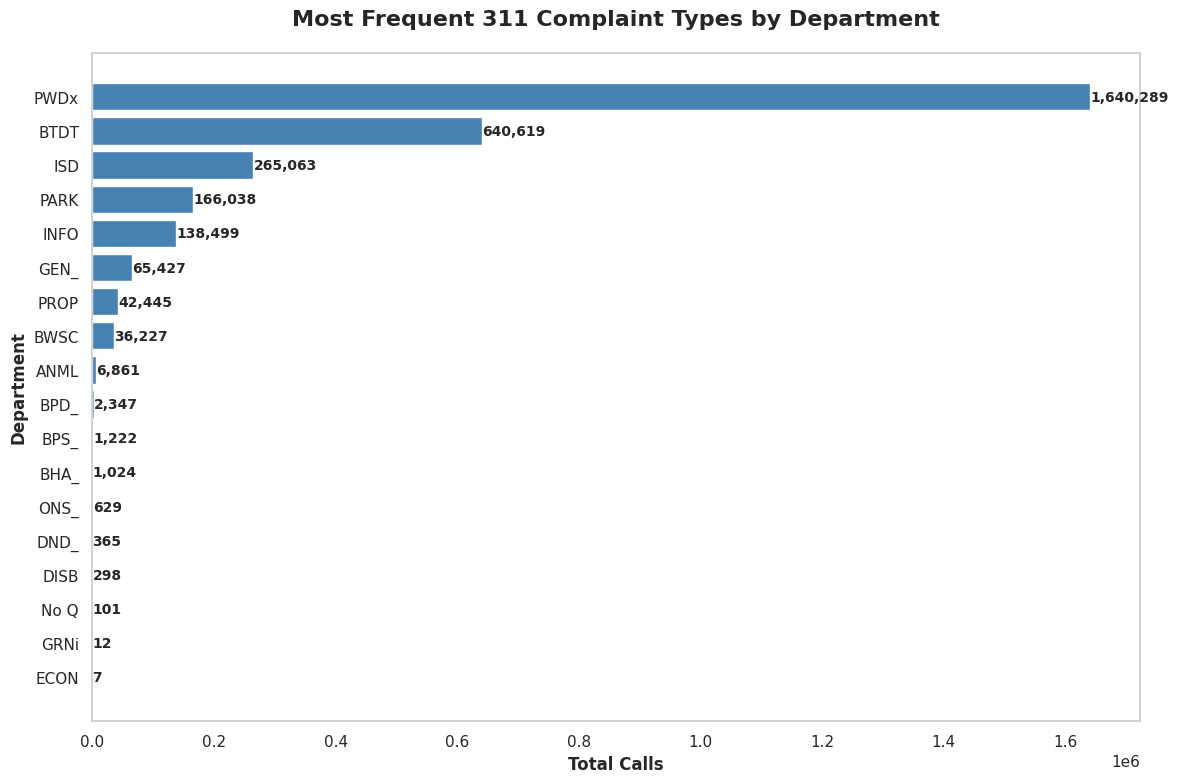

In [8]:
total_calls_by_department = df.groupby('department').size().reset_index(name='total_calls')
total_calls_by_department = total_calls_by_department.sort_values(by='total_calls', ascending=False)
irrelevant_departments = ["Test", "Temp"]
total_calls_by_department = total_calls_by_department[~total_calls_by_department['department'].isin(irrelevant_departments)]

# Set the style and color palette
sns.set_theme(style="whitegrid")
colors = sns.color_palette("Blues", len(total_calls_by_department))

# Plot the horizontal bar chart
plt.figure(figsize=(12, 8))
bars = plt.barh(
    total_calls_by_department['department'],
    total_calls_by_department['total_calls'],
    color='steelblue' 
)

# Add values to the bars
for bar in bars:
    value = int(bar.get_width())
    plt.text(value, bar.get_y() + bar.get_height() / 2,
             f'{value:,}',  # Format numbers with commas
             va='center', ha='left', weight='bold', fontsize=10)

# Customizing the chart
plt.title('Most Frequent 311 Complaint Types by Department', fontsize=16, weight='bold', pad=20)
plt.xlabel('Total Calls', weight='bold', fontsize=12)
plt.ylabel('Department', weight='bold', fontsize=12)
plt.gca().invert_yaxis()  # Invert y-axis to display highest values at the top
plt.grid(False)  # Remove gridlines

# Adjust layout for readability
plt.tight_layout()

# Show the chart
plt.show()